In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
import os
current_dir = os.getcwd()
os.chdir(current_dir.replace('\code', '\data'))

In [33]:
# Load data
passing = pd.read_csv('gross_passing_for_ml.csv')
rushing = pd.read_csv('gross_rushing_for_ml.csv')
receiving = pd.read_csv('gross_receiving_for_ml.csv')

passing.head()

,Player,Tm,Pos,Year,Age,Passing_Points,QBR,Career_Passing_Points,PC1_Passing,PC2_Passing,...,Future_Passing_Points,PC1_Team_Offense,PC2_Team_Offense,PC3_Team_Offense,PC4_Team_Offense,PC5_Team_Offense,PC6_Team_Offense,Pick,PC1_Combine,PC2_Combine
0,Drew Brees,NOR,QB,2012,33.0,341.08,68.7,NaN,8.092302,-0.478876,...,338.48,4.503140,-3.809227,-0.504070,0.063109,3.128906,-0.474781,32.0,1.154045,0.702856
1,Matthew Stafford,DET,QB,2012,24.0,244.68,56.1,NaN,6.689129,-0.823029,...,264.00,2.344107,-4.448034,3.526615,1.300930,0.169237,0.222835,1.0,NaN,NaN
2,Tony Romo,DAL,QB,2012,32.0,270.12,65.4,NaN,8.417567,-0.739280,...,257.12,1.301591,-5.033246,-0.176663,1.089347,0.039031,-0.739496,NaN,1.222625,-0.222408
3,Tom Brady,NWE,QB,2012,35.0,313.08,76.1,NaN,7.636002,-0.288475,...,251.72,7.672118,0.845387,2.386655,-1.772987,2.109157,1.195307,199.0,-2.094775,-0.345533
4,Matt Ryan,ATL,QB,2012,27.0,288.76,71.6,NaN,8.817859,-0.568901,...,250.60,3.149586,-2.730351,-1.043018,-3.223248,-0.452777,-3.749625,3.0,NaN,NaN


In [34]:
# Define transformation function
def transform_data(df, suffix='Passing_Points'):
    df = df.dropna(subset=['Future_'+suffix]).reset_index(drop=True)
    df = df.fillna(-1)
    df = pd.get_dummies(df, columns=['Pos'])
    columns_to_drop = ['Player', 'Tm', 'Year', 'Future_'+suffix]
    X = df.drop(columns=columns_to_drop)
    y = df['Future_'+suffix]
    return X, y

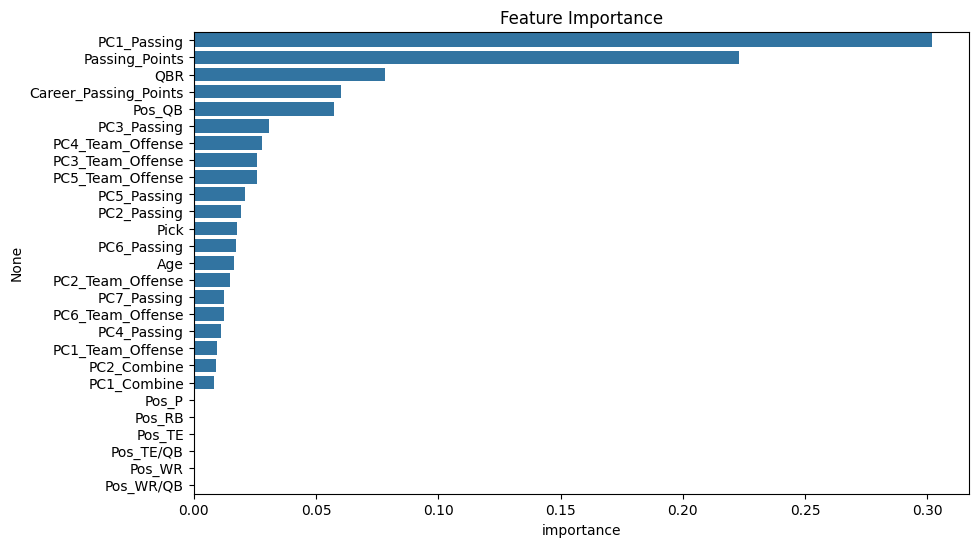

In [35]:
# feature importance
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
X, y = transform_data(pd.read_csv('gross_passing_for_ml.csv'), suffix='Passing_Points')
#X, y = transform_data(pd.read_csv('gross_rushing_for_ml.csv'), suffix='Rushing_Points')
#X, y = transform_data(pd.read_csv('gross_receiving_for_ml.csv'), suffix='Receiving_Points')
xgb = xgb.XGBRegressor(n_estimators=250, max_depth=3, learning_rate=0.1)
xgb.fit(X, y)
feature_importances = pd.DataFrame(xgb.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y=feature_importances.index, data=feature_importances)
plt.title('Feature Importance')
plt.show()

In [4]:
# Grid search for best hyperparameters
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Load data
X, y = transform_data(pd.read_csv('gross_passing_for_ml.csv'), suffix='Passing_Points')
#X, y = transform_data(pd.read_csv('gross_rushing_for_ml.csv'), suffix='Rushing_Points')
#X, y = transform_data(pd.read_csv('gross_receiving_for_ml.csv'), suffix='Receiving_Points')

# Define hyperparameters
param_grid = {
    'n_estimators': [10, 50, 250],
    'max_depth': [3, 6, 12],
    'learning_rate': [0.025, 0.1, 0.2]
}

# Define model
xgb = xgb.XGBRegressor()

# Grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X, y)
grid_search.best_params_

# Df for best hyperparameters
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results[['param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_fit_time', 
                    'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False).head(10)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


KeyboardInterrupt: 

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

def xgboost_model(X, y, n_estimators=10, max_depth=5, learning_rate=0.1):
    # Initialize the model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, 
                             max_depth=max_depth, learning_rate=learning_rate)
    scaler = StandardScaler()
    kf = KFold(n_splits=3, shuffle=True)

    # Initialize lists to store results
    r2_scores = []
    mse_scores = []
    predictions = np.zeros(len(y))

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2_scores.append(r2)
        mse_scores.append(mse)
        predictions[test_index] = y_pred

    # Add predictions to the original DataFrame
    X['XGBoost'] = predictions

    return X, y, np.mean(r2_scores), np.mean(mse_scores)

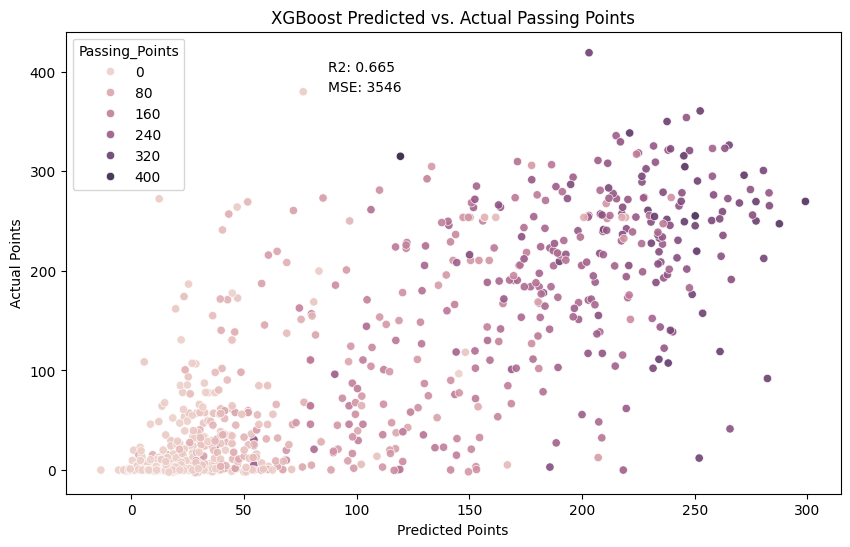

In [38]:
# Load data
X, y = transform_data(pd.read_csv('gross_passing_for_ml.csv'), suffix='Passing_Points')

# XGBoost
X, y, r2, mse = xgboost_model(X, y, n_estimators=50, max_depth=3, learning_rate=0.10)
passing = pd.concat([X, y], axis=1)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(y='Future_Passing_Points', x='XGBoost', data=passing, alpha=0.90, hue='Passing_Points')
plt.text(np.mean(passing['XGBoost']), 400, 'R2: {:.3f}'.format(r2))
plt.text(np.mean(passing['XGBoost']), 380, 'MSE: {:.0f}'.format(mse))
plt.xlabel('Predicted Points')
plt.ylabel('Actual Points')
plt.title('XGBoost Predicted vs. Actual Passing Points')
plt.show()

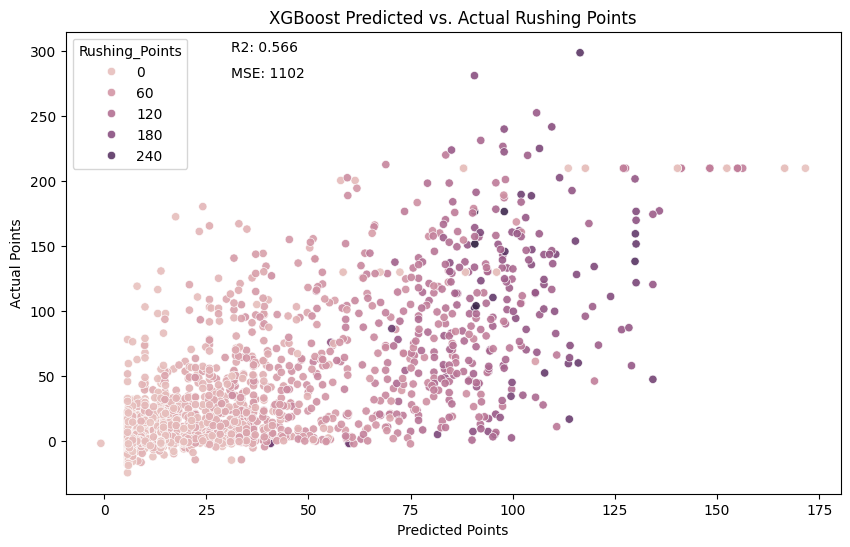

In [39]:
# Load data
X, y = transform_data(pd.read_csv('gross_rushing_for_ml.csv'), suffix='Rushing_Points')

# XGBoost
X, y, r2, mse = xgboost_model(X, y, n_estimators=10, max_depth=3, learning_rate=0.20)
rushing = pd.concat([X, y], axis=1)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(y='Future_Rushing_Points', x='XGBoost', data=rushing, alpha=0.90, hue='Rushing_Points')
plt.text(np.mean(rushing['XGBoost']), 300, 'R2: {:.3f}'.format(r2))
plt.text(np.mean(rushing['XGBoost']), 280, 'MSE: {:.0f}'.format(mse))
plt.xlabel('Predicted Points')
plt.ylabel('Actual Points')
plt.title('XGBoost Predicted vs. Actual Rushing Points')
plt.show()

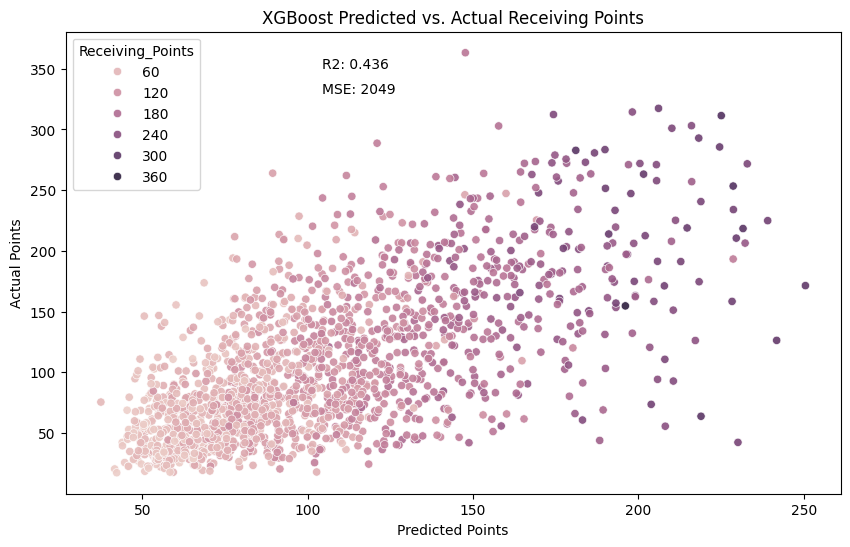

In [40]:
# Load data
X, y = transform_data(pd.read_csv('gross_receiving_for_ml.csv'), suffix='Receiving_Points')

# XGBoost
X, y, r2, mse = xgboost_model(X, y, n_estimators=50, max_depth=3, learning_rate=0.10)
receiving = pd.concat([X, y], axis=1)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(y='Future_Receiving_Points', x='XGBoost', data=receiving, alpha=0.90, hue='Receiving_Points')
plt.text(np.mean(receiving['XGBoost']), 350, 'R2: {:.3f}'.format(r2))
plt.text(np.mean(receiving['XGBoost']), 330, 'MSE: {:.0f}'.format(mse))
plt.xlabel('Predicted Points')
plt.ylabel('Actual Points')
plt.title('XGBoost Predicted vs. Actual Receiving Points')
plt.show()

In [119]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load data
df = pd.read_csv('gross_receiving_for_ml.csv')
X, y = transform_data(df, suffix='Receiving_Points')

# XGBoost
X, y, r2, mse = xgboost_model(X, y, n_estimators=50, max_depth=3, learning_rate=0.10)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

# Define the MLPRegressor
mlp = MLPRegressor(max_iter=10000, learning_rate='constant', solver='adam', activation='relu',
                   random_state=42)

# Define the grid of hyperparameters
param_grid = {
    'hidden_layer_sizes': [(100, 100), (50, 50, 50)],
    'alpha': [50, 10, 0.1],
    'tol': [75, 25]
}

# Perform grid search
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)

# Print the top 5 performing hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Test R2: {r2}")
print(f"Test MSE: {mse}")

# Add predictions to the original DataFrame
df['MLP'] = np.nan
df.loc[y_test.index, 'MLP'] = y_pred

Best: -2373.303302 using {'alpha': 50, 'hidden_layer_sizes': (50, 50, 50), 'tol': 25}
-2503.836580 (64.776063) with: {'alpha': 50, 'hidden_layer_sizes': (100, 100), 'tol': 75}
-2465.966920 (64.296552) with: {'alpha': 50, 'hidden_layer_sizes': (100, 100), 'tol': 25}
-2416.912857 (90.423821) with: {'alpha': 50, 'hidden_layer_sizes': (50, 50, 50), 'tol': 75}
-2373.303302 (78.126871) with: {'alpha': 50, 'hidden_layer_sizes': (50, 50, 50), 'tol': 25}
-2503.006264 (63.076305) with: {'alpha': 10, 'hidden_layer_sizes': (100, 100), 'tol': 75}
-2465.022876 (62.698254) with: {'alpha': 10, 'hidden_layer_sizes': (100, 100), 'tol': 25}
-2418.642529 (92.490129) with: {'alpha': 10, 'hidden_layer_sizes': (50, 50, 50), 'tol': 75}
-2375.786234 (79.720099) with: {'alpha': 10, 'hidden_layer_sizes': (50, 50, 50), 'tol': 25}
-2502.799473 (62.876194) with: {'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'tol': 75}
-2464.863360 (62.418996) with: {'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'tol': 25}
-241